In [5]:
#!pip install --upgrade pandas -q
!pip install --upgrade pandas-datareader -q

     |████████████████████████████████| 109 kB 8.6 MB/s 


In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

In [2]:
%cd /content/drive/MyDrive/Stock Prediction

/content/drive/MyDrive/Stock Prediction


In [3]:
start = '2000-01-01'
end = '2021-11-11'

df = web.DataReader('AAPL', 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856887
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784643
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.796124
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.727229
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761677


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-05,152.199997,150.059998,151.889999,151.279999,65414600.0,151.279999
2021-11-08,151.570007,150.160004,151.410004,150.440002,55020900.0,150.440002
2021-11-09,151.429993,150.059998,150.199997,150.809998,56787900.0,150.809998
2021-11-10,150.130005,147.850006,150.020004,147.919998,65187100.0,147.919998
2021-11-11,149.429993,147.679993,148.960007,147.869995,41000000.0,147.869995


In [5]:
df.reset_index(inplace=True)
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856887
1,2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784643
2,2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.796124
3,2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.727229
4,2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761677


In [6]:
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,High,Low,Open,Close,Volume
0,1.004464,0.907924,0.936384,0.999442,535796800.0
1,0.987723,0.903460,0.966518,0.915179,512377600.0
2,0.987165,0.919643,0.926339,0.928571,778321600.0
3,0.955357,0.848214,0.947545,0.848214,767972800.0
4,0.901786,0.852679,0.861607,0.888393,460734400.0


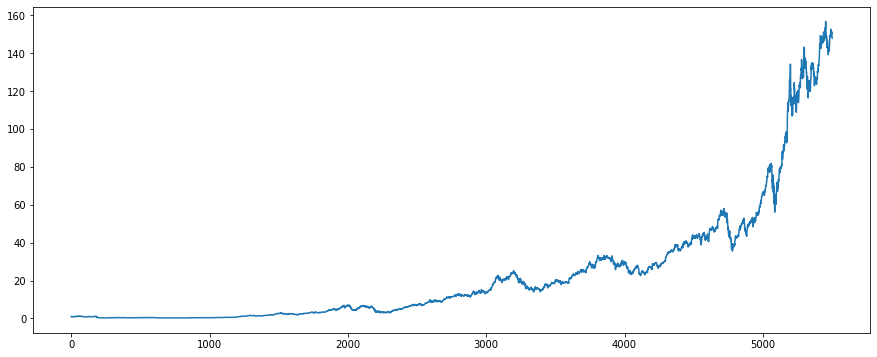

In [7]:
plt.figure(figsize = (15, 6))
plt.plot(df.Close)

In [ ]:
ma100 = df.Close.rolling(100).mean()
ma100

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5497    145.6864
5498    145.8729
5499    146.0764
5500    146.2326
5501    146.3715
Name: Close, Length: 5502, dtype: float64

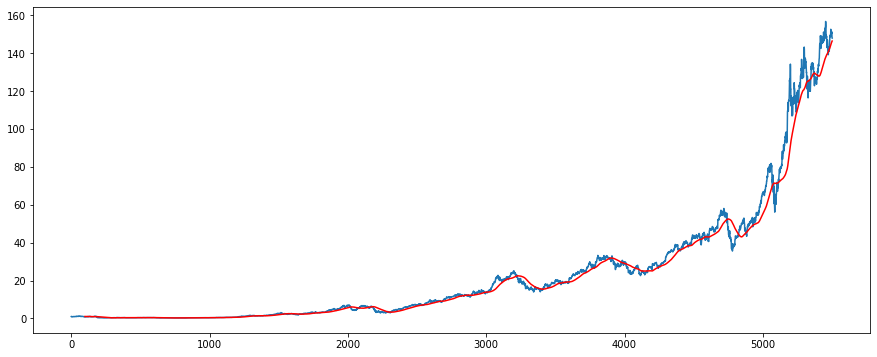

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(df.Close)
plt.plot(ma100, color = 'r')

In [ ]:
df.shape

(5502, 5)

In [8]:
train_data = pd.DataFrame(df['Close'][:int(0.7*len(df))])
val_data = pd.DataFrame(df['Close'][int(0.7*len(df)):int(0.85*len(df))])
test_data = pd.DataFrame(df['Close'][int(0.85*len(df)):])

train_data.shape, val_data.shape, test_data.shape

((3851, 1), (825, 1), (826, 1))

In [9]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)

In [10]:
step = 500
y_train = np.array([])
flag = 0

for i in range(step, scaled_train_data.shape[0]):
  if flag == 0:
    X_train = np.array(scaled_train_data[i-step:i, 0]) 
    flag = 1
  else:
    X_train = np.vstack((X_train, scaled_train_data[i-step:i, 0])) 
  y_train = np.append(y_train, scaled_train_data[i])

In [11]:
init_val_data = train_data.tail(step)
actual_val_data = init_val_data.append(val_data, ignore_index = True)
actual_val_data.head()

,Close
0,15.688929
1,15.911429
2,16.070715
3,16.453930
4,16.380714


In [12]:
len(actual_val_data) #len(val_data) + 100

1325

In [13]:
scaled_val_data = scaler.fit_transform(actual_val_data)

In [14]:
y_val = np.array([])
flag = 0

for i in range(step, scaled_val_data.shape[0]):
  if flag == 0:
    X_val = np.array(scaled_val_data[i-step:i, 0]) 
    flag = 1
  else:
    X_val = np.vstack((X_val, scaled_val_data[i-step:i, 0])) 
  y_val = np.append(y_val, scaled_val_data[i])

In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3351, 500), (3351,), (825, 500), (825,))

In [16]:
model = Sequential([LSTM(units = 64, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)),
                    Dropout(0.2),
                    LSTM(units = 64, activation = 'relu', return_sequences = True),
                    Dropout(0.2),
                    LSTM(units = 128, activation = 'relu'),
                    Dropout(0.2),
                    Dense(units = 1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 500, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.00005, patience = 5, mode = 'min', restore_best_weights	= True)
BATCH_SIZE = 32
model.compile(optimizer= 'adam', loss = 'mse')
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_val, y_val), batch_size = BATCH_SIZE, callbacks = [early_stopping])

Epoch 1/20
105/105 [==============================] - 113s 1s/step - loss: 0.0104 - val_loss: 0.0015
Epoch 2/20
105/105 [==============================] - 110s 1s/step - loss: 0.0014 - val_loss: 0.0022
Epoch 3/20
105/105 [==============================] - 110s 1s/step - loss: 0.0013 - val_loss: 0.0031
Epoch 4/20
105/105 [==============================] - 111s 1s/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/20
105/105 [==============================] - 110s 1s/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/20
105/105 [==============================] - 109s 1s/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/20
105/105 [==============================] - 109s 1s/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/20
105/105 [==============================] - 109s 1s/step - loss: 0.0011 - val_loss: 0.0016
Epoch 9/20
105/105 [==============================] - 109s 1s/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/20
105/105 [==============================] - 109s 1s/step - loss: 0.0012 - val_lo

In [18]:
history_df = pd.DataFrame(history.history)

In [19]:
history_df.head()

,loss,val_loss
0,0.010380,0.001501
1,0.001360,0.002157
2,0.001259,0.003089
3,0.001348,0.001493
4,0.001126,0.003060


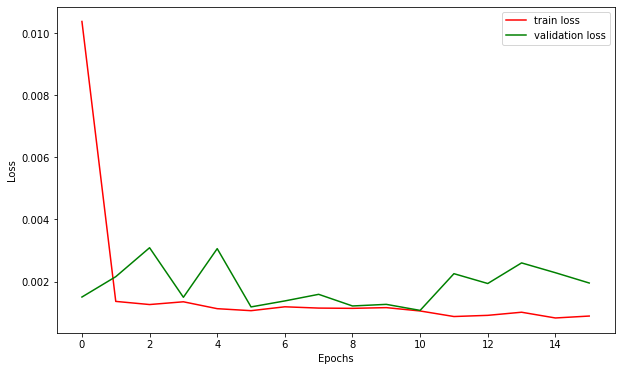

In [20]:
plt.figure(figsize = (10, 6))
plt.plot(history_df.loss, color = 'r', label = 'train loss')
plt.plot(history_df.val_loss, color = 'g', label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
model.save('model_2.h5')

In [22]:
model = load_model('model_2.h5')

In [23]:
test_data.head()

,Close
4676,51.997501
4677,52.267502
4678,51.777500
4679,51.812500
4680,52.220001


In [24]:
init_test_data = val_data.tail(step)
actual_test_data = init_test_data.append(test_data, ignore_index = True)
actual_test_data.head()

,Close
0,27.202499
1,27.000000
2,26.982500
3,27.045000
4,27.370001


In [25]:
len(actual_test_data) #len(test_data) + 100

1326

In [26]:
scaled_test_data = scaler.fit_transform(actual_test_data)
scaled_test_data[:10]

array([[0.01084735],
       [0.00930047],
       [0.00916678],
       [0.00964422],
       [0.01212689],
       [0.01193591],
       [0.01163036],
       [0.01136299],
       [0.01189772],
       [0.01027444]])

In [27]:
y_test = np.array([])
flag = 0

for i in range(step, scaled_test_data.shape[0]):
  if flag == 0:
    X_test = np.array(scaled_test_data[i-step:i, 0]) 
    flag = 1
  else:
    X_test = np.vstack((X_test, scaled_test_data[i-step:i, 0])) 
  y_test = np.append(y_test, scaled_test_data[i])

In [28]:
X_test.shape, y_test.shape

((826, 500), (826,))

In [29]:
y_pred = model.predict(X_test)
y_pred /= scaler.scale_
y_test /= scaler.scale_

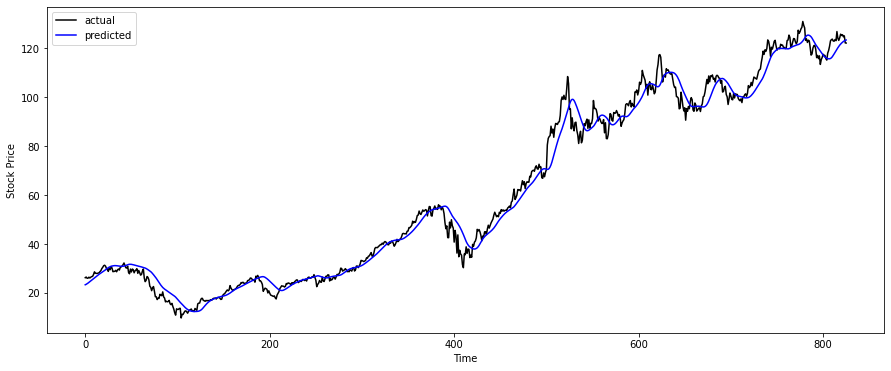

In [30]:
plt.figure(figsize = (15, 6))
plt.plot(y_test, color = 'black', label = 'actual')
plt.plot(y_pred, color = 'blue', label = 'predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()